# MA3315: Introduction to Visual Computing - 2020
## Assignment 1
Student : Mohamed KERROUMI<br>
Contact : mohamed.kerroumi@student.ecp.fr<br>

This assignment has two problems. 

Let us load the required libraries first. 

In [0]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import random
from tqdm import tqdm_notebook

%matplotlib inline

## 1. The Bilateral Filter

For the first problem, we will have to implement the bilateral filter for smoothingof the images.
* You can use the valve image that you can find in your folder to validate the filter.
* Test the filtering and plot the results for neighhoods of 3x3 and 5x5
* Evaluate the performance with the Gaussian smoothing visually and write a small comment with some conclusions

In [0]:
neigh = 3
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def gaussian(x, sigma):
    return (np.exp(- (x ** 2) / (2 * sigma ** 2))/ (2 * np.pi * (sigma ** 2)))

def filter_point(x , y, img, neigh=10):
    I = 0 
    G = 0
    r , c = img.shape
    sigma_s, sigma_r = 12 , 16
    for i in range(-neigh+1, neigh):
        for j in range(-neigh+1, neigh):
            if  (-1<i +x<r) & (-1<j +y<c):
                G1 =  gaussian(np.linalg.norm([i,j]), sigma_s)
                G2 =  gaussian(img[x,y] - img[i+x, j+y], sigma_r)
                G  +=  G1 * G2 
                I  +=  G1 * G2 * img[i+x, j+y]
    I = int(round(I/G))

    return(I)
def bilateral_filtering(img, neigh):
    """
    The Bilateral Filtering.
    
    Inputs:
        img              The input image
        neigh            The neighborhoud of pixels
                         
    Outputs: 
        bilateral_img    A smoothed image
    """
    
    # Write the function here
    r , c = img.shape
    filterred_img = np.zeros(img.shape)
    for l in range(r):
        for k in range(c):
            filterred_img[l,k] = filter_point(l,k,img,neigh)
    # Return the result
    return(filterred_img)

In [5]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bilateral1 = bilateral_filtering(img, 3)
bilateral2 = bilateral_filtering(img, 5)
smoothed_img = ndimage.gaussian_filter(img, sigma=(2, 2), order=0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()


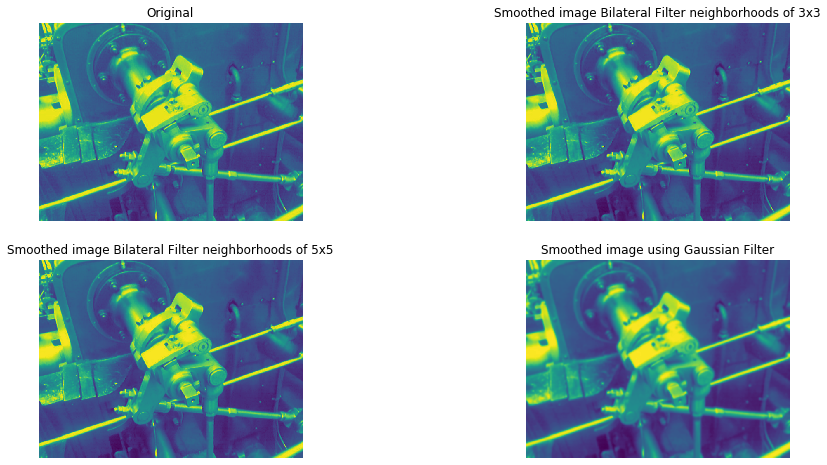

In [6]:
plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
plt.imshow(bilateral1)
plt.axis('off')
plt.title('Smoothed image Bilateral Filter neighborhoods of 3x3')

plt.subplot(2, 2, 3)
plt.imshow(bilateral2)
plt.axis('off')
plt.title('Smoothed image Bilateral Filter neighborhoods of 5x5')

plt.subplot(2, 2, 4)
plt.imshow(smoothed_img)
plt.axis('off')
plt.title('Smoothed image using Gaussian Filter')
plt.show()

- We observe that the output image of the Bilateral Filter with 5 x 5 neighborhoods is more smoothed than the one with 3 x 3 Bilateral Filter.
- Although the Bilateral Filter takes a lot of time to smooth the image, It is better than the gaussian filter, because the gaussian filter has a very bad effect on the edges.

## 2. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 2.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`


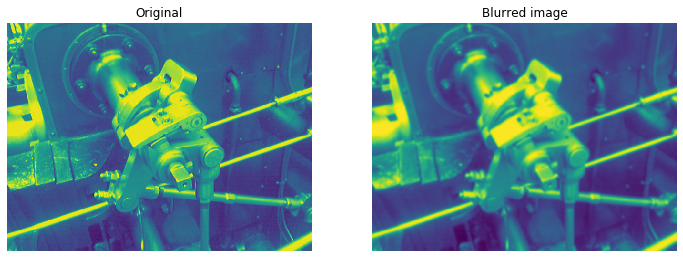

In [7]:
#Smoothing the image using a Gaussian filter
blurred_img = ndimage.gaussian_filter(img, sigma=(2, 2), order=0)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(blurred_img)
plt.axis('off')
plt.title('Blurred image')

plt.show()


#### 2.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$


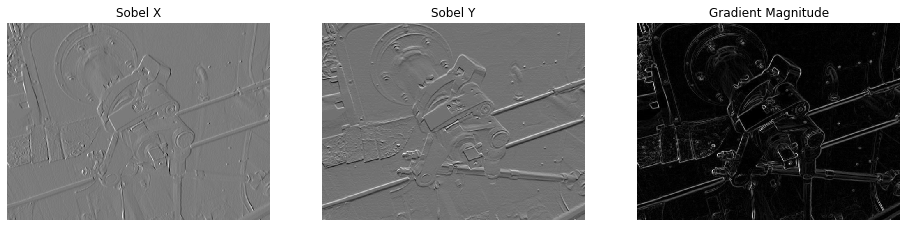

In [8]:
#Computing the gradient of the image—magnitude and direction—using the Sobel operator

sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
Mag = np.sqrt(sobelx**2 + sobely**2)
Dir = np.arctan(sobely/(sobelx+ 10**(-3)))

plt.figure(figsize=(16,8))

plt.subplot(1, 3, 1)
plt.imshow(sobelx,cmap = 'gray')
plt.axis('off')
plt.title('Sobel X')

plt.subplot(1, 3, 2)
plt.imshow(sobely,cmap = 'gray')
plt.axis('off')
plt.title('Sobel Y')


plt.subplot(1, 3, 3)
plt.imshow(Mag,cmap = 'gray')
plt.axis('off')
plt.title('Gradient Magnitude')

plt.show()


#### 2.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.



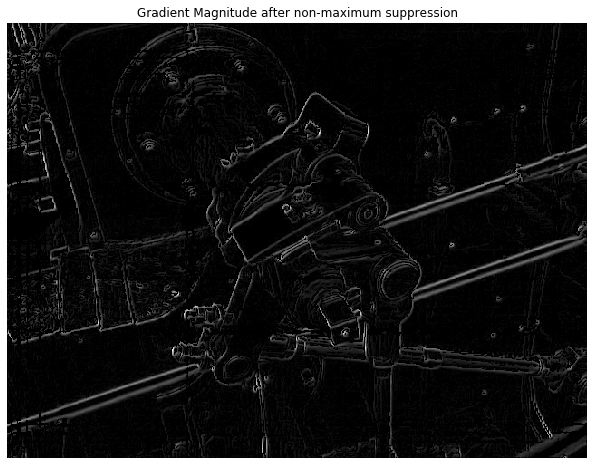

In [9]:
def quantize(x):
    #quantise the gradient directions into four values — 0 ,  π/4 ,  π/2 , and  3π/4
    x_ = x + (x<0)* np.pi
    x_ = (x_<np.pi/4)*(x_>= 0)*0 + (x_>=np.pi/4)*(x_< np.pi/2)*(np.pi/4) + (x_>=np.pi/2)*(x_< 3*np.pi/4) * np.pi/2 + (x_<=np.pi)*(x_>= np.pi*3/4)* np.pi*3/4
    return(x_)
def neighbour(Mag, Dir, i , j):
  #Returns the magnitude of the gradient in  two neighbours found when moving in the direction perpendicular to the edge 
  #of a particular point.
    n, m =np.shape(Mag)
    if Dir[i,j] == 0 :
        return(Mag[i,j], Mag[i,min(j-1,0)], Mag[i, min(m-1, j+1)])
    if Dir[i,j] == np.pi/4  :
        return(Mag[i,j], Mag[min(i+1,n-1),min(j-1,0)], Mag[min(i-1,0), min(m-1, j+1)])    
    if Dir[i,j] == np.pi/2 :
        return(Mag[i,j], Mag[min(i-1,0), j], Mag[min(n-1, i+1), j])
    if Dir[i,j] == np.pi*3/4  :
        return(Mag[i,j], Mag[min(i-1,0),min(j-1,0)], Mag[min(i+1,n-1), min(m-1, j+1)])
def max_supp(Mag, Dir):
   #suppress gradients at all points that are not greater than the two neighbours 
    Dir = quantize(Dir)
    n, m =np.shape(Mag)
    grad_ = np.zeros(Mag.shape)
    for i in range(n):
        for j in range(m):
            m1,m2,m3  = neighbour(Mag,Dir,i,j)
            if (m1>=m2) & (m1>=m3):
                grad_[i,j] = Mag[i,j] 
    return(grad_)
Mag_ = max_supp(Mag, Dir)
plt.figure(figsize=(16,8))
plt.imshow(Mag_,cmap = 'gray')
plt.axis('off')
plt.title('Gradient Magnitude after non-maximum suppression')

plt.show()

#### 2.D Double thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than `hi` will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 



In [0]:
hi, lo  = 75 , 25
Thr1 = (Mag_>=hi)
Thr2 = (Mag_>=lo) * (Mag_<hi)

#### 2.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

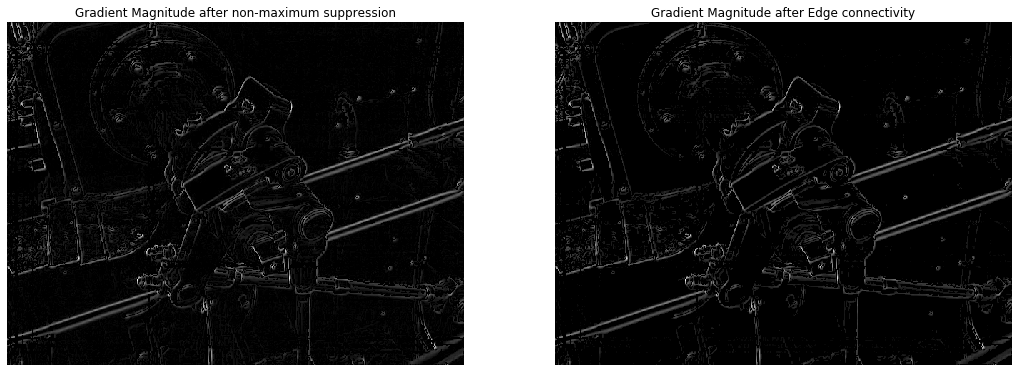

In [11]:
def connect(Thr1, Thr2):
    n, m = Thr1.shape
    Thr = np.zeros(Thr1.shape)
    for i in range(n):
        for j in range(m):
            if Thr2[i,j]>0:
                S = Thr1[i,min(j-1,0)]+ Thr1[i, min(m-1, j+1)] + Thr1[min(i+1,n-1),min(j-1,0)]+ Thr1[min(i-1,0), min(m-1, j+1)]+ Thr1[min(i-1,0), j]+ Thr1[min(n-1, i+1), j]+ Thr1[min(i-1,0),min(j-1,0)]+ Thr1[min(i+1,n-1), min(m-1, j+1)]
                if S>0:
                    Thr[i,j] = 1
    return(Thr1 + Thr)
Thr = connect(Thr1, Thr2)
Mag1 =Mag_*Thr
plt.figure(figsize=(18,9))

plt.subplot(1, 2, 1)
plt.imshow(Mag_,cmap = 'gray')
plt.axis('off')
plt.title('Gradient Magnitude after non-maximum suppression')

plt.subplot(1, 2, 2)
plt.imshow(Mag1,cmap = 'gray')
plt.axis('off')
plt.title('Gradient Magnitude after Edge connectivity')

plt.show()

In [0]:
def canny_edge_detector(img, thresh_lo=15, thresh_hi=45):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = ndimage.gaussian_filter(img, sigma=(2, 2), order=0)
    
    # Find gradient magnitude and direction
    sobelx = cv2.Sobel(smoothed,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(smoothed,cv2.CV_64F,0,1,ksize=3)
    g_magnitude, g_dir = np.sqrt(sobelx**2 + sobely**2), np.arctan(sobely/(sobelx+ 10**(-3)))
    
    # Non-maximum suppression
    g_max                = max_supp(g_magnitude, g_dir)
    
    # Double thresholding
    Thr1 = (g_max>=thresh_hi)
    Thr2 = (g_max>=thresh_lo) * (g_max<thresh_hi)
    
    # Final edge connectivity
    edge_img             = connect(Thr1, Thr2)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

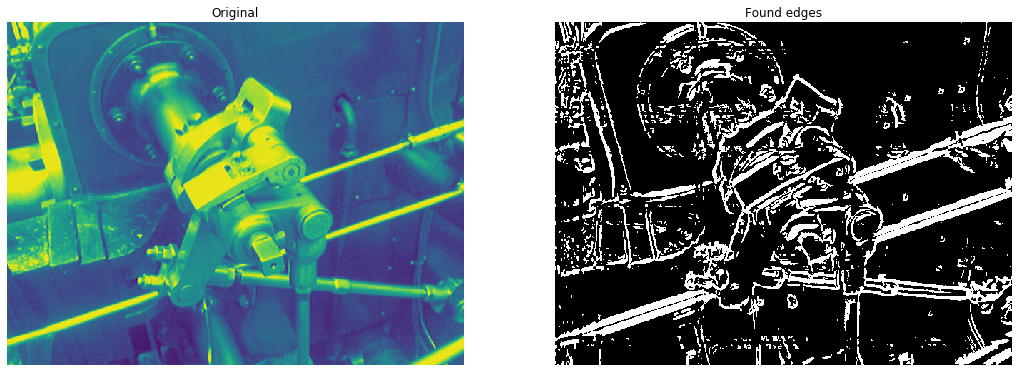

In [13]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = canny_edge_detector(img)

plt.figure(figsize=(18,9))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Found edges')

plt.show()

## 3. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

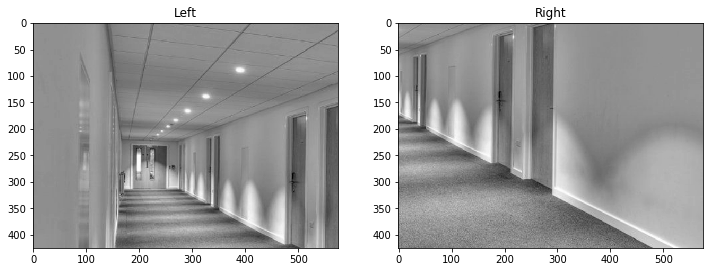

In [14]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
#plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
#plt.axis('off')
plt.title('Right')

plt.show()

In [0]:
def harris_corner_detector(img):
    
    n, l = np.shape(img)
    K1 = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    I_x = convolve2d(img, K1, mode='valid')
    K2 = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    I_y = convolve2d(img, K2, mode='valid')    
    
    Ixx = ndimage.gaussian_filter(I_x**2, sigma=1)
    Iyy = ndimage.gaussian_filter(I_y**2, sigma=1)
    Ixy = ndimage.gaussian_filter(I_x*I_y, sigma=1)
    
    
    det = Ixx * Iyy - Ixy**2
    k=0.05
    trace = Ixx + Iyy
    H = det - k * trace**2
    L=[]
    m = H.max()
    for i in range(n-2 ):
        for j in range(l-2 ):
            if H[i,j] > 0.09 * m:
                L.append((i,j))
    return L

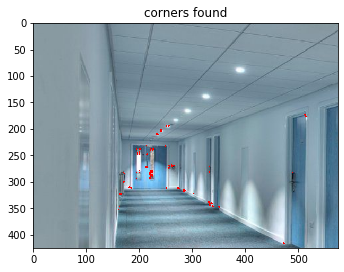

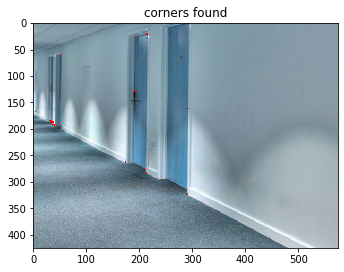

In [16]:
def plot_edges(harris_response,img,  original_image):
    harris_response = harris_corner_detector(img)
    img_copy_for_corners = np.copy(original_image)

    for (i,j) in harris_response:
        img_copy_for_corners[i,j] = [255,0,0]
    plt.figure(figsize=(12,6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_copy_for_corners)
    plt.title("corners found")  
    plt.show()

harris_response_left  = harris_corner_detector(left_img)
harris_response_right = harris_corner_detector(right_img)
plot_edges(harris_response_left,left_img,  cv2.imread('left.png'))
plot_edges(harris_response_right,right_img,  cv2.imread('right.png'))

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images implementing by your own the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [0]:
def match(img1 , img2 , x1 ,y1, x2, y2):
    #Matchs two images based on one commun point, (x1,y1) are coordinates of the point in the first img,
    #(x2,y2) are coordinates of the point in the second img,
    n , m = img1.shape
    
    #Shape of the stitched image
    N, M = max(x1,x2) + max(n-x1, n- x2) ,max(y1,y2) + max(m-y1, m- y2)
    x , y = max(x1,x2) , max(y1,y2)
    
    #Transition vectors
    trans1 = (x-x1,y-y1)
    trans2 = (x-x2,y-y2)
    
    #Coordinates of the pixels of input images in the new stitched image
    pairs1 = {}
    pairs2 = {}
    for i in range(n):
        for  j in range(m):
            pairs1[(i +trans1[0], j+trans1[1])] = img1[i,j]
            pairs2[(i +trans2[0], j+trans2[1])] = img2[i,j]
    
    #Pixels commun for the left and right image.
    Intersection = list(set(pairs1.keys()).intersection(pairs2.keys()))
    
    # MSE of intensity between commun pixels.
    error = 0
    L = len(Intersection)
    for w in Intersection:
        error += (pairs1[w] - pairs2[w])**2
    
    #Intensity of the stitched image based on the left and right image.
    stitched_image = np.zeros((N,M))
    for (k,l) in pairs1.keys():
        stitched_image[k,l] = pairs1[(k,l)]
    for  (k,l) in pairs2.keys():
        if (k,l) not in pairs1.keys():
            stitched_image[k,l] = pairs2[(k,l)]
    
    return(x ,y ,error/L, stitched_image)

def stitch_images(left, right, max_tries=1000):
    # Find corner points
    corners_left  = harris_corner_detector(left)
    corners_right = harris_corner_detector(right)

    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in tqdm_notebook(range(max_tries)):
        # Choose two points randomly
        (x1,y1), (x2,y2)  = random.choice(corners_left), random.choice(corners_right)
        
        # Get translation vector
        # Compute resulting error. 
        x_trans, y_trans , this_error, new_img = match(left , right , x1 ,y1, x2, y2)
        
        if this_error < best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
            stitched_image  = new_img
    return stitched_image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


Text(0.5, 1.0, 'stitched_image')

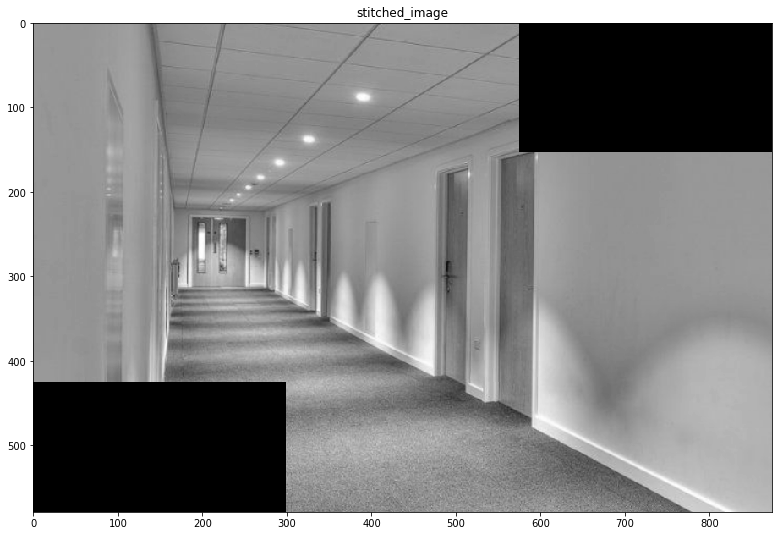

In [20]:
new_img = stitch_images(left_img, right_img, max_tries=200)
plt.figure(figsize=(18,9))
plt.imshow(new_img, cmap='gray')
plt.title('stitched_image')

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 